<h1> Classification

<h2> MNIST dataset 

The MNIST dataset is not available by fetch_mldata <br> 
Alternative way to load the data set: https://github.com/ageron/handson-ml/issues/301

In [2]:
import pandas as pd 
import numpy as np 

In [3]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_train.shape,y_train.shape

((60000, 28, 28), (60000,))

In [5]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [6]:
X_train.dtype

dtype('uint8')

In [7]:
type(X_train)

numpy.ndarray

<h3> Display one digit

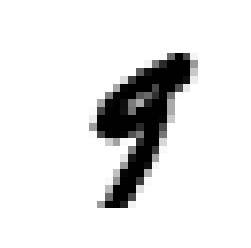

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

plot_digit(X_train[36000])
plt.show()

In [9]:
y_train[36000]

9

In [10]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

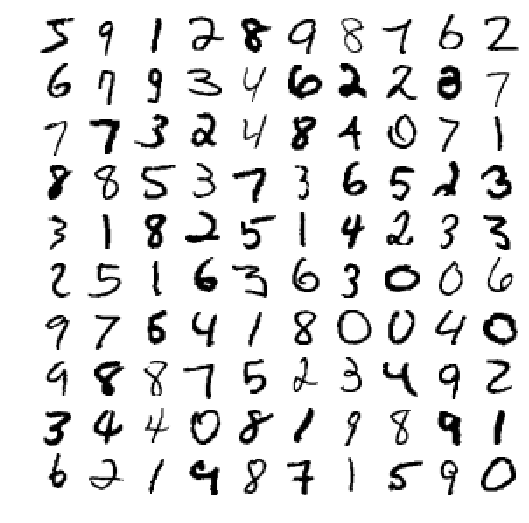

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X_train[:12000:600], X_train[13000:30600:600], X_train[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [12]:
# if the dataset was sorted, we will need to shuffle the data 
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

<h2> Binary Classifier 

We will use number 5 

In [13]:
y_train_5 = (y_train == 5)

In [14]:
y_test_5 = (y_test == 5) 

In [15]:
y_train_5[:40]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False])

In [16]:
# count how many numbers are 5 in training set
np.count_nonzero(y_train == 5)

5421

Conver to 2 dmin

In [17]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1] * X_train.shape[2]))

In [18]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1] * X_test.shape[2]))

In [19]:
X_train.shape

(60000, 784)

Testing with SDG classifier

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
some_digit = X_train[221]
y_train[221]


6

In [22]:
sgd_clf.predict([some_digit])

array([False])

Measure the accuracy 

In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9673, 0.9694, 0.9604])

In [24]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [25]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9073 , 0.9122 , 0.90945])

Conusion matrix

In [26]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53745,   834],
       [ 1224,  4197]])

True Negative = 53627 <br>
False Positive (Predicted as True when Actual is False) = 952 <br>
False Negative (Predicted as False when Actual is True) = 1110 <br>
True Positive = 4311 

In [28]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8342277877161598

<h4>Precision is the accuracy of the positive predictions (with total of predicted as true, how many predictions were actually correct)

In [29]:
recall_score(y_train_5, y_train_pred)

0.7742114001106807

<h4> Recall is the ratio of positive instances that are correctly detected by the clasifier (with total of actual correct, How many predictions were predicted as correct )

It corrects only 82% of the time and only detects 80% of 5s

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8030998851894374

<h3> Picking the right threshold

SDGclassifier computes a score based on a decision function whcih uses threshold.

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

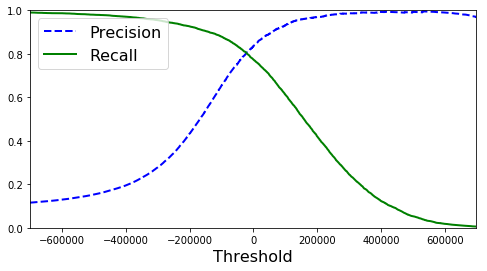

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
# save_fig("precision_recall_vs_threshold_plot")
plt.show()

<h2> Try with RandomForest

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

/anaconda3/envs/NLP/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/NLP/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/NLP/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [36]:
y_probas_forest.shape

(60000, 2)

<h3> Comparing the ROC curve with SDGclassifier and Random Forest

In [42]:
from sklearn.metrics import roc_curve
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

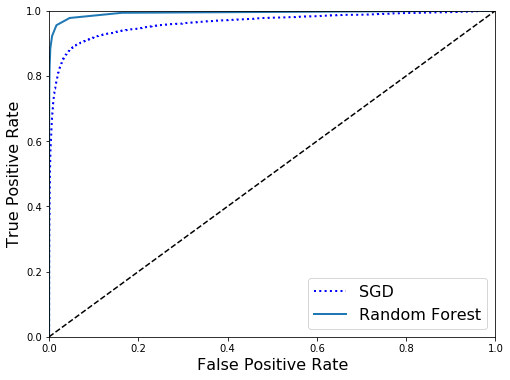

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
# save_fig("roc_curve_comparison_plot")
plt.show()

In [47]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores),roc_auc_score(y_train_5, y_scores_forest)

(0.9621516288358266, 0.992975627404752)

-Score is higher for the Random Forest!!

Lets' calcultae the precision and recall

In [50]:
# since we used method="predict_proba" above, but this time we need to get the prediction of y, 
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)


/anaconda3/envs/NLP/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/NLP/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/NLP/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9855263157894737

In [53]:
precision_score(y_train_5, y_train_pred_forest),recall_score(y_train_5,y_train_pred_forest)

(0.9855263157894737, 0.8289983397897067)

<h2> Multiclass Classification

In [55]:
sgd_clf.fit(X_train, y_train) # we are using y_train where it contains 0-9 not only 5 
sgd_clf.predict([some_digit]) # some_digit is 6

array([6], dtype=uint8)

In [57]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [58]:
some_digit_scores # notice at 6th position its the highest score

array([[-578982.11727499, -772097.95941647, -466620.18316358,
        -612722.16986987, -431408.30751322, -330411.08863809,
         202859.88920554, -888255.63331645, -240640.71797579,
        -396177.7949872 ]])

In [59]:
np.argmax(some_digit_scores) # argmax returns the index of max number

6

In [61]:
sgd_clf.classes_[6] #when trained, it stores the list of target classes in its classes_ attribute

6

<h3> One-vs-One / One-vs-All

In [62]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([6], dtype=uint8)

In [63]:
len(ovo_clf.estimators_) # (n-1)*n/2 times it'll compare 

45

In [64]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/anaconda3/envs/NLP/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([6], dtype=uint8)

In [65]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [66]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86307738, 0.86374319, 0.8673301 ])

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90796841, 0.90954548, 0.91148672])

 <h2>An MNIST Classifier With Over 97% Accuracy

In [69]:
# using GridSearch and KNNClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

More on Tuning: https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/

In [70]:
knn_clf = KNeighborsClassifier()
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': list(range(1, 11))}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1,scoring='accuracy')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# view the complete results (list of named tuples)
grid.grid_scores_

In [ ]:
# examine the best model

# Single best score achieved across all params (k)
print(grid.best_score_)

# Dictionary containing the parameters (k) used to generate that score
print(grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid.best_estimator_)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

<h3>Exercise 2: Shifting image

In [71]:
from scipy.ndimage.interpolation import shift

In [72]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    # Shift:　The shift along the axes. If a float, shift is the same for each axis. If a sequence, shift should contain one value for each axis.
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1]) #conreshaping back to 28*28

<b> What is Reshape with -1 </b><br>
A.reshape(-1, 28**28)
means, "reshape A so that its second dimension has a size of 28*28 and calculate the correct size of the first dimension".

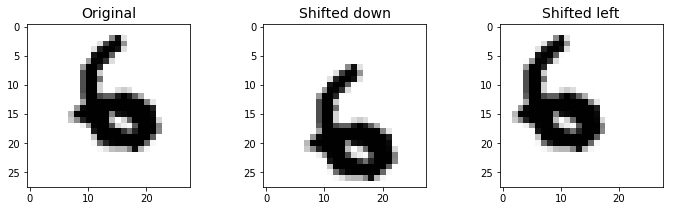

In [73]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [74]:
shifted_image_down.shape

(784,)

In [75]:
image.shape

(784,)

In [76]:
# convert it to row list and then append new data, convert back to array 
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [77]:
type(X_train_augmented)

numpy.ndarray

Shuffle the data

In [78]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
# try fit it with model that we already train previously on excersize 1
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)